# Stable Diffusion v2.1 using OpenVINO TorchDynamo backend

> **Note:** This notebook has been moved to a new branch named "latest". [Click here](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/stable-diffusion-torchdynamo-backend/stable-diffusion-torchdynamo-backend.ipynb) to get the most updated version of the notebook. This branch is deprecated.

Stable Diffusion v2 is the next generation of Stable Diffusion model a Text-to-Image latent diffusion model created by the researchers and engineers from [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). 

General diffusion models are machine learning systems that are trained to denoise random gaussian noise step by step, to get to a sample of interest, such as an image.
Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference. OpenVINO brings capabilities to run model inference on Intel hardware and opens the door to the fantastic world of diffusion models for everyone!

This notebook demonstrates how to run stable diffusion model using [Diffusers](https://huggingface.co/docs/diffusers/index) library and [OpenVINO `TorchDynamo` backend](https://docs.openvino.ai/2024/openvino-workflow/torch-compile.html) for Text-to-Image and Image-to-Image generation tasks.

Notebook contains the following steps:

1. Create pipeline with PyTorch models.
2. Add OpenVINO optimization using OpenVINO TorchDynamo backend.
3. Run Stable Diffusion pipeline with OpenVINO.




#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Stable Diffusion with Diffusers library](#Stable-Diffusion-with-Diffusers-library)
- [OpenVINO TorchDynamo backend](#OpenVINO-TorchDynamo-backend)
    - [Run Image generation](#Run-Image-generation)
- [Interactive demo](#Interactive-demo)
- [Support for Automatic1111 Stable Diffusion WebUI](#Support-for-Automatic1111-Stable-Diffusion-WebUI)



In [1]:
import sys
from IPython.display import HTML, display

sys.path.append("../utils")
from ipython_exit import exit

if sys.platform == "win32":
    display(HTML("""<div class="alert alert-danger">Currently notebook does not support Windows platform"""))
    exit()

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [2]:
%pip install -q torch transformers diffusers gradio ipywidgets --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "openvino>=2023.3.0"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import gradio as gr
import random
import torch
import time

from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
import ipywidgets as widgets

## Stable Diffusion with Diffusers library
[back to top ⬆️](#Table-of-contents:)

To work with Stable Diffusion v2.1, we will use Hugging Face Diffusers library. To experiment with Stable Diffusion models, Diffusers exposes the [StableDiffusionPipeline](https://huggingface.co/docs/diffusers/using-diffusers/conditional_image_generation) and [StableDiffusionImg2ImgPipeline](https://huggingface.co/docs/diffusers/using-diffusers/img2img) similar to the other [Diffusers pipelines](https://huggingface.co/docs/diffusers/api/pipelines/overview). The code below demonstrates how to create the `StableDiffusionPipeline` using `stable-diffusion-2-1-base` model:

In [4]:
model_id = "stabilityai/stable-diffusion-2-1-base"

# Pipeline for text-to-image generation
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## OpenVINO TorchDynamo backend
[back to top ⬆️](#Table-of-contents:)

The [OpenVINO TorchDynamo backend](https://docs.openvino.ai/2024/openvino-workflow/torch-compile.html) lets you enable [OpenVINO](https://docs.openvino.ai/2024/home.html) support for PyTorch models with minimal changes to the original PyTorch script. It speeds up PyTorch code by JIT-compiling it into optimized kernels. By default, Torch code runs in eager-mode, but with the use of torch.compile it goes through the following steps:
1. Graph acquisition - the model is rewritten as blocks of subgraphs that are either:
   - compiled by TorchDynamo and “flattened”,
   - falling back to the eager-mode, due to unsupported Python constructs (like control-flow code).
2. Graph lowering - all PyTorch operations are decomposed into their constituent kernels specific to the chosen backend.
3. Graph compilation - the kernels call their corresponding low-level device-specific operations.

Select device for inference and enable or disable saving the optimized model files to a hard drive, after the first application run. This makes them available for the following application executions, reducing the first-inference latency. Read more about available [Environment Variables options](https://docs.openvino.ai/2024/openvino-workflow/torch-compile.html#options)

In [5]:
from openvino import Core

core = Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="CPU",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='CPU')

In [6]:
model_caching = widgets.Dropdown(
    options=[True, False],
    value=True,
    description="Model caching:",
    disabled=False,
)

model_caching

Dropdown(description='Model caching:', options=(True, False), value=True)

To use [`torch.compile()` method](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html), you just need to add an import statement and define the OpenVINO backend:

In [ ]:
# this import is required to activate the openvino backend for torchdynamo
import openvino.torch  # noqa: F401

pipe.unet = torch.compile(pipe.unet, backend="openvino", options={"device": device.value, "model_caching": model_caching.value})

> **Note**: Read more about available [OpenVINO backends](https://docs.openvino.ai/2024/openvino-workflow/torch-compile.html#how-to-use)

> **Note**: Currently, PyTorch does not support torch.compile feature on Windows officially. Please follow [these instructions](https://docs.openvino.ai/2024/openvino-workflow/torch-compile.html#windows-support) if you want to access it on Windows.

### Run Image generation
[back to top ⬆️](#Table-of-contents:)


  0%|          | 0/50 [00:00<?, ?it/s]

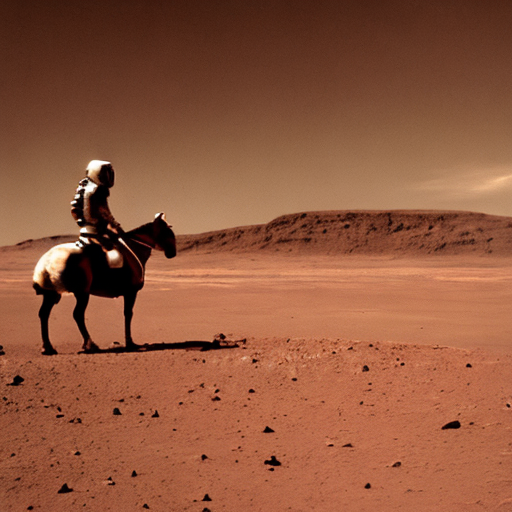

In [8]:
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]
image

# Interactive demo
[back to top ⬆️](#Table-of-contents:)

Now you can start the demo, choose the inference mode, define prompts (and input image for Image-to-Image generation) and run inference pipeline.
Optionally, you can also change some input parameters.

In [9]:
time_stamps = []
def callback(iter, t, latents):
    time_stamps.append(time.time())


def error_str(error, title="Error"):
    return f"""#### {title}
            {error}""" if error else ""


def on_mode_change(mode):
    return gr.update(visible=mode == modes['img2img']), \
        gr.update(visible=mode == modes['txt2img'])


def inference(inf_mode, prompt, guidance=7.5, steps=25, width=768, height=768, seed=-1, img=None, strength=0.5, neg_prompt=""):
    if seed == -1:
        seed = random.randint(0, 10000000)
    generator = torch.Generator().manual_seed(seed)
    res = None

    global time_stamps, pipe
    time_stamps = []
    try:
        if inf_mode == modes['txt2img']:
            if type(pipe).__name__ != "StableDiffusionPipeline":
                pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
                pipe.unet = torch.compile(pipe.unet, backend="openvino")
            res = pipe(prompt,
                       negative_prompt=neg_prompt,
                       num_inference_steps=int(steps),
                       guidance_scale=guidance,
                       width=width,
                       height=height,
                       generator=generator,
                       callback=callback,
                       callback_steps=1).images
        elif inf_mode == modes['img2img']:
            if img is None:
                return None, None, gr.update(visible=True, value=error_str("Image is required for Image to Image mode"))
            if type(pipe).__name__ != "StableDiffusionImg2ImgPipeline":
                pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
                pipe.unet = torch.compile(pipe.unet, backend="openvino")
            res = pipe(prompt,
                       negative_prompt=neg_prompt,
                       image=img,
                       num_inference_steps=int(steps),
                       strength=strength,
                       guidance_scale=guidance,
                       generator=generator,
                       callback=callback,
                       callback_steps=1).images           
    except Exception as e:
        return None, None, gr.update(visible=True, value=error_str(e))
    
    warmup_duration = time_stamps[1] - time_stamps[0]
    generation_rate = (steps - 1) / (time_stamps[-1] - time_stamps[1])
    res_info = "Warm up time: " + str(round(warmup_duration, 2)) + " secs "
    if (generation_rate >= 1.0):
        res_info = res_info + ", Performance: " + str(round(generation_rate, 2)) + " it/s "
    else:
        res_info = res_info + ", Performance: " + str(round(1 / generation_rate, 2)) + " s/it "

    return res, gr.update(visible=True, value=res_info), gr.update(visible=False, value=None)


modes = {
    'txt2img': 'Text to Image',
    'img2img': 'Image to Image',
}

with gr.Blocks(css="style.css") as demo:
    gr.HTML(
        f"""
            Model used: {model_id}         
        """
    )
    with gr.Row():

        with gr.Column(scale=60):
            with gr.Group():
                prompt = gr.Textbox("a photograph of an astronaut riding a horse", label="Prompt", max_lines=2)
                neg_prompt = gr.Textbox("frames, borderline, text, character, duplicate, error, out of frame, watermark, low quality, ugly, deformed, blur", label="Negative prompt")
                res_img = gr.Gallery(label="Generated images", show_label=False)
            error_output = gr.Markdown(visible=False)

        with gr.Column(scale=40):
            generate = gr.Button(value="Generate")

            with gr.Group():
                inf_mode = gr.Dropdown(list(modes.values()), label="Inference Mode", value=modes['txt2img'])
                
                with gr.Column(visible=False) as i2i:
                    image = gr.Image(label="Image", height=128, type="pil")
                    strength = gr.Slider(label="Transformation strength", minimum=0, maximum=1, step=0.01, value=0.5)

            with gr.Group():
                with gr.Row() as txt2i:
                    width = gr.Slider(label="Width", value=512, minimum=64, maximum=1024, step=8)
                    height = gr.Slider(label="Height", value=512, minimum=64, maximum=1024, step=8)

            with gr.Group():
                with gr.Row():
                    steps = gr.Slider(label="Steps", value=20, minimum=1, maximum=50, step=1)
                    guidance = gr.Slider(label="Guidance scale", value=7.5, maximum=15)

                seed = gr.Slider(-1, 10000000, label='Seed (-1 = random)', value=-1, step=1)
            
            res_info = gr.Markdown(visible=False)

    inf_mode.change(on_mode_change, inputs=[inf_mode], outputs=[
                    i2i, txt2i], queue=False)

    inputs = [inf_mode, prompt, guidance, steps,
              width, height, seed, image, strength, neg_prompt]
    
    outputs = [res_img, res_info, error_output]
    prompt.submit(inference, inputs=inputs, outputs=outputs)
    generate.click(inference, inputs=inputs, outputs=outputs)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)

# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


## Support for Automatic1111 Stable Diffusion WebUI
[back to top ⬆️](#Table-of-contents:)

Automatic1111 Stable Diffusion WebUI is an open-source repository that hosts a browser-based interface for the Stable Diffusion based image generation. It allows users to create realistic and creative images from text prompts. Stable Diffusion WebUI is supported on Intel CPUs, Intel integrated GPUs, and Intel discrete GPUs by leveraging OpenVINO torch.compile capability. Detailed instructions are available in[ Stable Diffusion WebUI repository](https://github.com/openvinotoolkit/stable-diffusion-webui/wiki/Installation-on-Intel-Silicon).